https://www.mdeditor.tw/pl/pP6Q/zh-tw

In [54]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [55]:


# Import data : Internet Usage per Minute
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df =pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv" , index_col = None)


In [56]:
df

,PART_NO,EQP_NO,STOCK_EVENT_TIME,QTY,PM,TS,ENG,NST,MFG_MONTH
0,85-ECT0010,ECT11,2015-01-31,0,0.0,0.0,0.0,0.0,201501
1,85-ECT0010,ECT11,2015-02-28,0,0.0,0.0,0.0,0.0,201502
2,85-ECT0010,ECT11,2015-03-31,0,0.0,0.0,0.0,0.0,201503
3,85-ECT0010,ECT11,2015-04-30,0,0.0,0.0,0.0,0.0,201504
4,85-ECT0010,ECT11,2015-05-31,0,0.0,0.0,0.0,0.0,201505
...,...,...,...,...,...,...,...,...,...
20770,85-EMA0920,EWA53,2020-11-30,0,0.0,0.0,0.0,0.0,202011
20771,85-EMA0920,EWA53,2020-12-31,0,0.0,0.0,0.0,0.0,202012
20772,85-EMA0920,EWA53,2021-01-31,0,0.0,0.0,0.0,0.0,202101
20773,85-EMA0920,EWA53,2021-02-28,0,0.0,0.0,0.0,0.0,202102


In [57]:

df_parts = df[df['PART_NO']=='86-DIA0120']  
# Original Series


In [58]:
df_parts.groupby(['PART_NO','MFG_MONTH']).sum().reset_index()

,PART_NO,MFG_MONTH,QTY,PM,TS,ENG,NST
0,86-DIA0120,201501,0,0.0,0.0,0.0,0.0
1,86-DIA0120,201502,0,0.0,0.0,0.0,0.0
2,86-DIA0120,201503,0,0.0,0.0,0.0,0.0
3,86-DIA0120,201504,0,0.0,0.0,0.0,0.0
4,86-DIA0120,201505,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
70,86-DIA0120,202011,72,36.0,36.0,0.0,0.0
71,86-DIA0120,202012,95,95.0,0.0,0.0,0.0
72,86-DIA0120,202101,47,47.0,0.0,0.0,0.0
73,86-DIA0120,202102,144,72.0,36.0,0.0,36.0


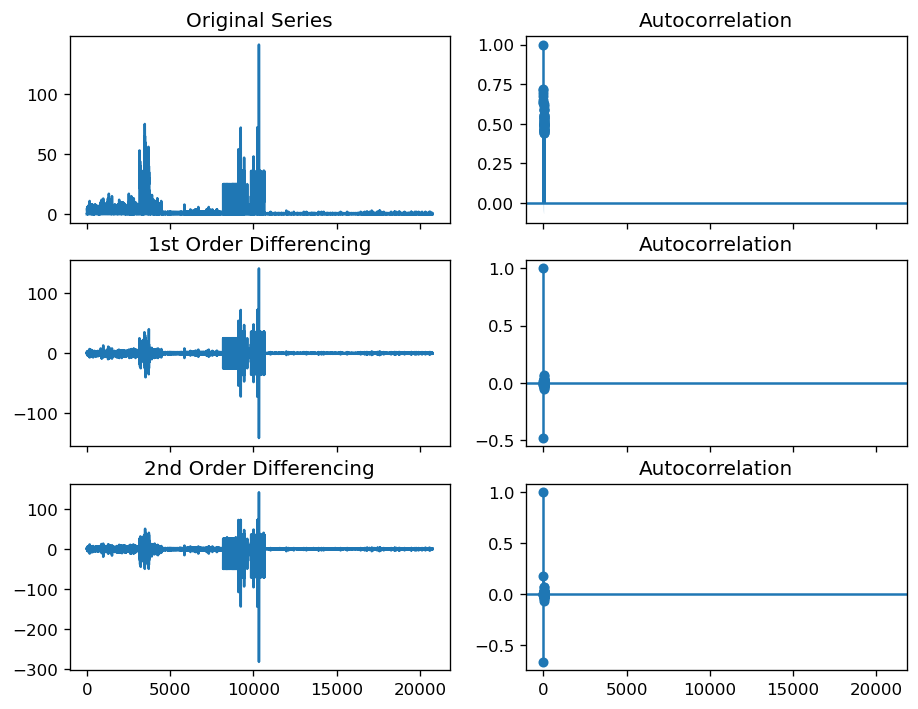

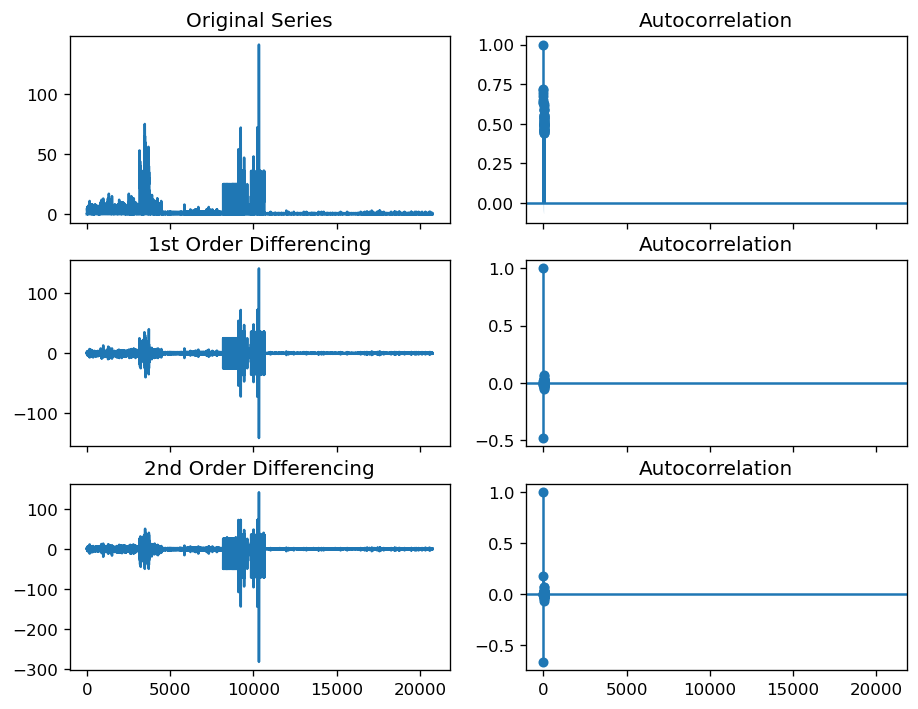

In [59]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['QTY']); axes[0, 0].set_title('Original Series')
plot_acf(df['QTY'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['QTY'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['QTY'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['QTY'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['QTY'].diff().diff().dropna(), ax=axes[2, 1])

# plt.show()

# 構建ARIMA模型

In [60]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['QTY'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.QTY   No. Observations:                20774
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -54004.678
Method:                       css-mle   S.D. of innovations              3.256
Date:                Tue, 13 Apr 2021   AIC                         108019.357
Time:                        21:59:44   BIC                         108059.064
Sample:                             1   HQIC                        108032.324
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0002      0.001     -0.137      0.891      -0.002       0.002
ar.L1.D.QTY     0.9433      0.005    206.335      0.000       0.934       0.952
ma.L1.D.QTY    -1.6686      0.008   -208.128    

# 檢查殘差
通常會檢查模型擬合的殘差序列，即訓練資料原本的序列減去訓練資料上的擬合序列後的序列。該序列越符合隨機誤差分佈(均值為0的正態分佈)，說明模型擬合的越好，否則，說明還有一些因素模型未能考慮。

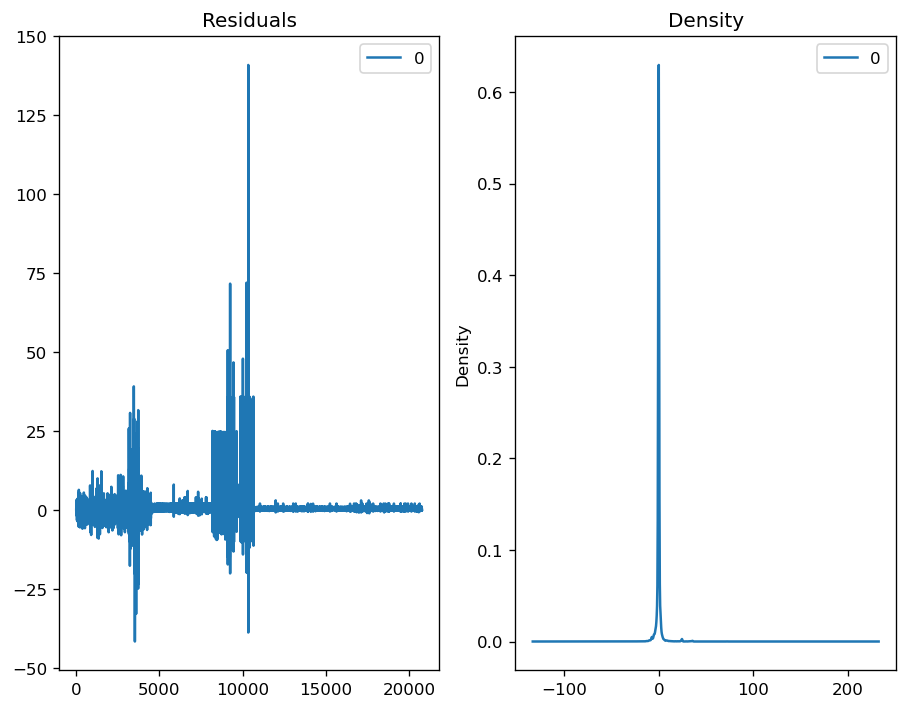

In [61]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# 模型擬合


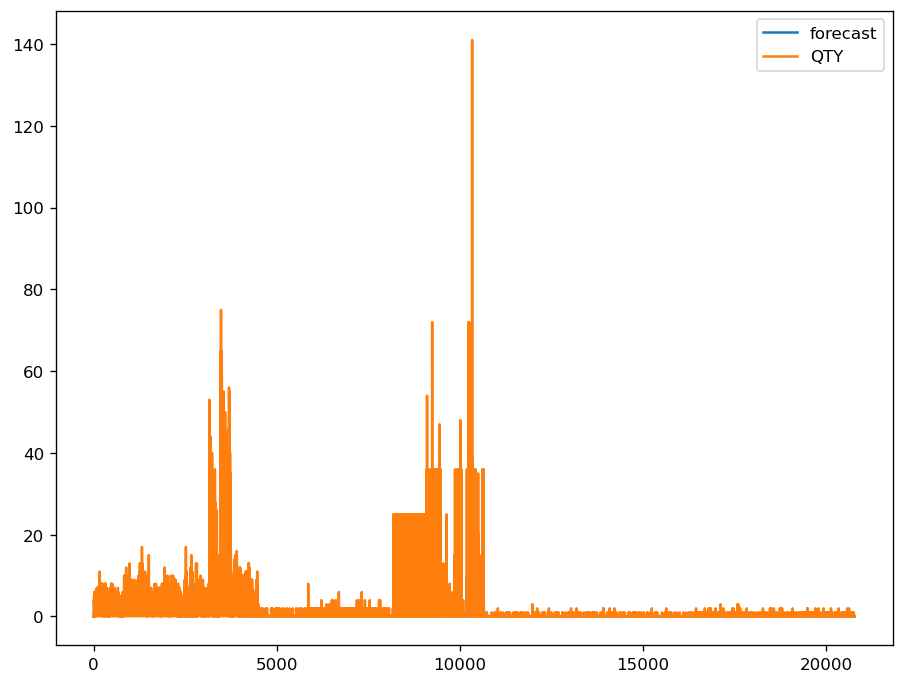

In [62]:

# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

# 模型預測
除了在訓練資料上擬合，一般都會預留一部分時間段作為模型的驗證，這部分時間段的資料不參與模型的訓練。

In [64]:
df.shape

(20775, 9)

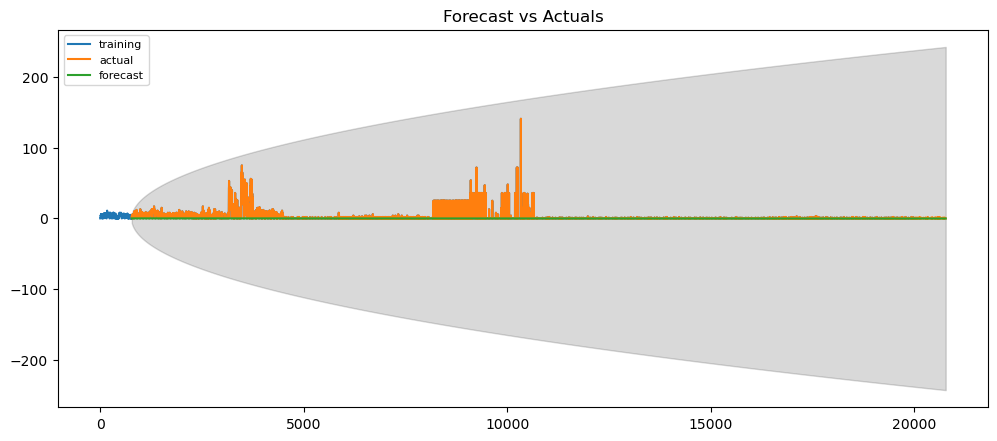

In [66]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df['QTY'][:20000]
test = df['QTY'][775:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(20000, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# AUTO ARIMA

In [67]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df['QTY'], start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=108178.658, Time=1.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=130936.766, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=114178.845, Time=0.49 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=122632.313, Time=0.88 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=108180.510, Time=2.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=108180.526, Time=2.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=118560.035, Time=1.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=110424.262, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=108181.683, Time=1.83 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=108158.292, Time=6.44 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=121513.289, Time=4.62 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=113921.288, Time=1.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=108160.269, Time=8.47 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=108160.271, Time=10.34 sec
 ARI

AttributeError: 'DataFrame' object has no attribute 'value'

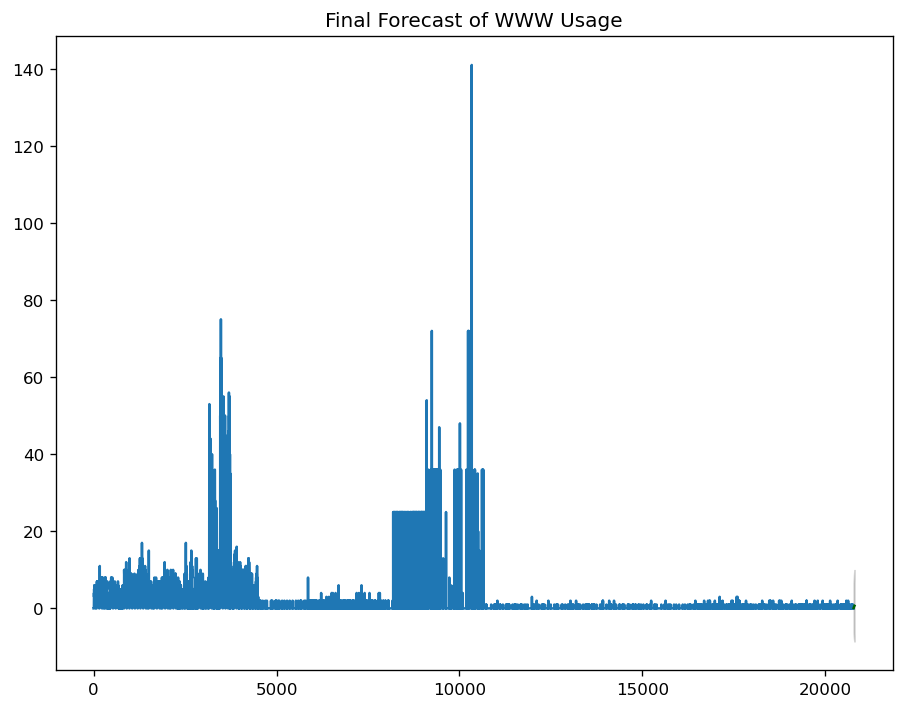

In [69]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['QTY']), len(df['QTY'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df['QTY'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

上節介紹的auto arima的程式碼中，seasonal引數設為了false，構建季節性模型的時候，把該引數置為True，然後對應的P，D，Q,m引數即可，程式碼如下：

In [70]:
# !pip3 install pyramid-arima
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df['QTY'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

NameError: name 'data' is not defined

In [ ]:
ef load_data():
    """
    航司乘客數時間序列資料集
    該資料集包含了1949-1960年每個月國際航班的乘客總數。
    """
    from datetime import datetime
    date_parse = lambda x: datetime.strptime(x, '%Y-%m-%d')
    data = pd.read_csv('https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv', index_col='Month', parse_dates=['Month'], date_parser=date_parse)
    # print(data)
    # print(data.index)
    ts = data['value']
    # print(ts.head(10))
    # plt.plot(ts)
    # plt.show()
    return ts,data

In [ ]:
# 載入時間序列資料
_ts,_data = load_data()
# 時間序列分解
result_mul = seasonal_decompose(_ts[-36:],  # 3 years
                                model='multiplicative',
                                freq=12,
                                extrapolate_trend='freq')
_seasonal_frame = result_mul.seasonal[-12:].to_frame()
_seasonal_frame['month'] = pd.to_datetime(_seasonal_frame.index).month
# seasonal_index = result_mul.seasonal[-12:].index
# seasonal_index['month'] = seasonal_index.month.values
print(_seasonal_frame)
_data['month'] = _data.index.month
print(_data)
_df = pd.merge(_data, _seasonal_frame, how='left', on='month')
_df.columns = ['value', 'month', 'seasonal_index']
print(_df)
print(_df.index)
_df.index = _data.index  # reassign the index.
print(_df.index)

build_arima(_df,_seasonal_frame,_data)

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']],
						exogenous=df[['seasonal_index']],
						start_p=1, start_q=1,
						test='adf',
						max_p=3, max_q=3, m=12,
						start_P=0, seasonal=False,
						d=1, D=1, trace=True,
						error_action='ignore',
						suppress_warnings=True,
						stepwise=True)
sxmodel.summary()
# Forecast
n_periods = 36
fitted, confint = sxmodel.predict(n_periods=n_periods,
								  exogenous=np.tile(seasonal_frame['y'].values, 3).reshape(-1, 1),
								  return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['y'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
				 lower_series,
				 upper_series,
				 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()